# Anomaly detection pipeline

> Fill in a module description here

In [1]:
# | default_exp ad_complete

In [2]:
# | hide
from nbdev.showdoc import *

In [3]:
# | export
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from ts_vae_lstm.concepts import get_window
from scipy import signal
import os
import math
import torch

In [4]:
# | export

from torch import nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, accuracy_score

In [5]:
# | export
from ts_vae_lstm.vae import VAE, Encoder, Decoder, StochasticSampler
from fastcore.xtras import noop
from dotenv import load_dotenv

t
t_unit
readings
idx_anomaly
idx_split
training
test
train_m
train_std
t_train
t_test
idx_anomaly_test


/home/gg/.local/share/virtualenvs/ts_vae-lstm-hz-Oy2CQ/lib/python3.9/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [6]:
# | export
load_dotenv()

BASEDIR = os.getenv("BASEDIR")
MODELDIR = os.getenv("MODELDIR")
VAE_MODEL = os.getenv("VAE_MODEL")
LSTM_MODEL = os.getenv("LSTM_MODEL")

print(f"LSTM model: {LSTM_MODEL}\nVAE model: {VAE_MODEL}")

LSTM model: /run/media/data2/ts_vae-lstm/models/lstm_100_val0.81.pth
VAE model: /run/media/data2/ts_vae-lstm/models/vae_100_z24.pth


In [7]:
num_workers = os.cpu_count()
device = "cuda" if torch.cuda.is_available() else "cpu"
num_workers, device

(4, 'cpu')

Train a VAE with no anomalies in the time series.

```--> Anomalies occur at:
  timestamp #0: 2014-11-01 19:00:00
  timestamp #1: 2014-11-27 15:30:00
  timestamp #2: 2014-12-25 15:00:00
  timestamp #3: 2015-01-01 01:00:00
  timestamp #4: 2015-01-27 00:00:00

Original csv file contains (10320,) timestamps.
Processed time series contain (10320,) readings.
Anomaly indices are [5943, 7184, 8527, 8835, 10081]

Training set mean is 14855.115757575757
Training set std is 6556.134705703313
Anomaly indices in the test set are [2643 3884 5227 5535 6781]```

In [8]:
data = np.load(f"{BASEDIR}/sample_data/nyc_taxi.npz")
for k in data.keys():
    print(k)

t
t_unit
readings
idx_anomaly
idx_split
training
test
train_m
train_std
t_train
t_test
idx_anomaly_test


In [9]:
data["test"].shape

(4820,)

In [10]:
test_m, test_std = data["test"].mean(), data["test"].std()
test_m, test_std

(-0.030322429151081194, 1.0493333785801708)

In [11]:
data_test_norm = (data["test"] - test_m) / test_std
data_test_norm.mean(), data_test_norm.std()

(2.358648085510706e-17, 0.9999999999999999)

In [12]:
train_m, train_std = data["training"].mean(), data["training"].std()
train_m, train_std

(-9.818408712321384e-17, 1.0)

In [13]:
data_test_norm = (data_test_norm * train_std) + train_m
data_test_norm

array([0.53649793, 0.55448895, 0.4132313 , ..., 1.72615445, 1.62523604,
       1.58264792])

In [14]:
df = pd.DataFrame(
    data_test_norm,  # data["test"],  # - data["train_m"]) / data["train_std"],
    index=data["t_test"],
    columns=["value"],
)
df.head(2)

,value
1,0.536498
2,0.554489


normalize the test data with the means from train

In [15]:
df.mean(), df.std()

(value   -4.127634e-17
 dtype: float64,
 value    1.000104
 dtype: float64)

In [16]:
p = 48  # so that one window is one day

data = [
    {
        "subset": get_window(
            df.values,
            window_size=p,
            end_step=t,
            indices=list(df.index),
            return_indices=False,
        ),
        "end_step": t,
        "start_step": t - p,
    }
    for t in range(
        p, len(df), p
    )  # take steps every 48 so that we end up with non-overlapping sequences
]

In [17]:
vae_model = torch.load(VAE_MODEL, map_location=device)
vae_model

VAE(
  (encoder): Encoder(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (conv1): Conv2d(1, 64, kernel_size=(5, 1), stride=(2, 1))
    (conv2): Conv2d(64, 512, kernel_size=(5, 1), stride=(2, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear): Linear(in_features=4608, out_features=512, bias=False)
    (linear_mean): Linear(in_features=512, out_features=24, bias=False)
    (linear_var): Linear(in_features=512, out_features=24, bias=False)
  )
  (decoder): Decoder(
    (linear): Linear(in_features=24, out_features=512, bias=False)
    (dconv1): ConvTranspose2d(512, 512, kernel_size=(5, 1), stride=(2, 2))
    (dconv2): ConvTranspose2d(512, 64, kernel_size=(5, 1), stride=(2, 2))
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [18]:
@torch.no_grad()
def get_embeddings(x, n_windows=1, latent_dim=32, seq_len=1, sampler_repeat=200):
    """
    _summary_

    Parameters
    ----------
    x : _type_
        _description_
    n_windows : int, optional
        _description_, by default 1
    latent_dim : int, optional
        _description_, by default 32
    seq_len : int, optional
        _description_, by default 1
    sampler_repeat : int, optional
        Number of times to repeatedly sample from the sampler to ensure we have enough variablity in the embedding, by default 10

    Returns
    -------
    _type_
        _description_
    """
    # actual_shape = x.shape[0]
    vae_model.eval()
    x = (
        torch.from_numpy(x.astype(np.float32)).view(n_windows, -1, seq_len).to(device)
    )  # p, seq -> n_windows, p, seq
    embedded_x = torch.zeros(n_windows, latent_dim, seq_len).to(device)
    for idx in range(n_windows):
        batched_x_window = x[idx].unsqueeze(0)
        # print(batched_x_window.shape)
        z_mean, z_log_var = vae_model.encoder(batched_x_window)
        for _ in range(sampler_repeat):
            # explore multiple potential future embeddings by sampling from the latent space multiple times (Monte Carlo sampling).
            embedded_x[idx] += (
                vae_model.latent_sampler(z_mean, z_log_var).permute(1, 0)
                / sampler_repeat
            )

        # reshape
    embedded_x = embedded_x.reshape(latent_dim * n_windows, -1)
    return embedded_x

In [19]:
get_embeddings(data[0]["subset"], latent_dim=24, sampler_repeat=1)

tensor([[-1.1162],
        [-0.6177],
        [ 0.9496],
        [ 0.0659],
        [-0.3395],
        [ 0.5848],
        [ 0.5230],
        [ 0.3429],
        [ 0.7156],
        [ 0.2479],
        [ 1.3845],
        [-0.2441],
        [-0.0588],
        [ 0.6809],
        [-1.1954],
        [-0.3005],
        [ 0.9971],
        [ 0.3035],
        [-0.7928],
        [-1.4273],
        [ 1.4949],
        [-1.8884],
        [ 0.3921],
        [ 0.1850]])

In [20]:
data_embeddings = [
    {
        "subset": get_embeddings(
            data[i]["subset"], latent_dim=24, n_windows=1, seq_len=1, sampler_repeat=1
        ),
        "end_step": data[i]["end_step"],
        "start_step": data[i]["start_step"],
    }
    for i in range(len(data))
]

We have now the testing embeddings. Can have already one benchmark with VAE reconstruction. But we now pass this to the LSTM model to predict expected embedding for next window.

In [21]:
from ts_vae_lstm.lstm import LSTMModel

In [22]:
lstm_model = torch.load(LSTM_MODEL, map_location=device)
lstm_model

LSTMModel(
  (lstm_input): LSTM(23, 64, batch_first=True, bidirectional=True)
  (lstm_hidden): LSTM(128, 128, batch_first=True, bidirectional=True)
  (lstm_output): LSTM(256, 23, batch_first=True)
  (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (ln3): LayerNorm((23,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.45, inplace=False)
)

In [23]:
data_embeddings[0]["subset"].shape

torch.Size([24, 1])

In [24]:
data_embeddings[0]["subset"].unsqueeze(0).shape

torch.Size([1, 24, 1])

In [41]:
@torch.no_grad()
def predict_next_embeddings(data, device="cpu", batch_size=1, latent_dim=24, seq_len=1):
    lstm_model.eval()
    data = data.view(batch_size, latent_dim, seq_len).to(device)
    data_first = data[:, 0, :].unsqueeze(1)
    data_next = data[:, 1:, :]
    embeddings = lstm_model(data_next)
    embeddings = torch.concat([data_first, embeddings], dim=1)
    return embeddings

In [42]:
x_emb.shape

torch.Size([1, 24, 1])

In [43]:
x_emb = data_embeddings[0]["subset"].unsqueeze(0)
next_x_emb = predict_next_embeddings(x_emb, device=device, latent_dim=24, seq_len=1)

In [44]:
p, next_x_emb.shape

(48, torch.Size([1, 24, 1]))

In [45]:
predicted_embeddings = [
    {
        "prev_subset": data_embeddings[i]["subset"],
        "next_subset": predict_next_embeddings(
            data_embeddings[i]["subset"].unsqueeze(0),
            device=device,
            latent_dim=24,
            seq_len=1,
        ),
        # since we predict for the fututure
        "start_step": data_embeddings[i]["start_step"] + p,
        "end_step": data_embeddings[i]["end_step"] + p,
    }
    for i in range(len(data_embeddings))
]

In [46]:
predicted_embeddings[0].keys()

dict_keys(['prev_subset', 'next_subset', 'start_step', 'end_step'])

In [47]:
@torch.no_grad()
def decode_embeddings(data, device="cpu", batch_size=1, latent_dim=24):
    vae_model.eval()
    data = data.view(batch_size, latent_dim).to(device)
    ts = vae_model.decoder.to(device)(data)
    return ts.cpu().squeeze(0).numpy()

In [48]:
next_x_ts = decode_embeddings(predicted_embeddings[0]["next_subset"])
next_x_ts.shape

(48, 1)

In [49]:
predicted_ts = [
    {
        "prev_subset": decode_embeddings(
            predicted_embeddings[i]["prev_subset"],
            device=device,
            latent_dim=24,
        ),
        "next_subset": decode_embeddings(
            predicted_embeddings[i]["next_subset"],
            device=device,
            latent_dim=24,
        ),
        # since we predict for the fututure
        "start_step": predicted_embeddings[i]["start_step"],
        "end_step": predicted_embeddings[i]["end_step"],
    }
    for i in range(len(predicted_embeddings))
]

In [50]:
data[0]["subset"].shape  # actual data

(48, 1)

In [51]:
predicted_ts[0]["prev_subset"].shape  # decoded by vae_model.decoder

(48, 1)

In [52]:
data[1]["subset"].shape  # actual next subset

(48, 1)

In [53]:
predicted_ts[0]["next_subset"].shape  # predicted next subset

(48, 1)

<Axes: >

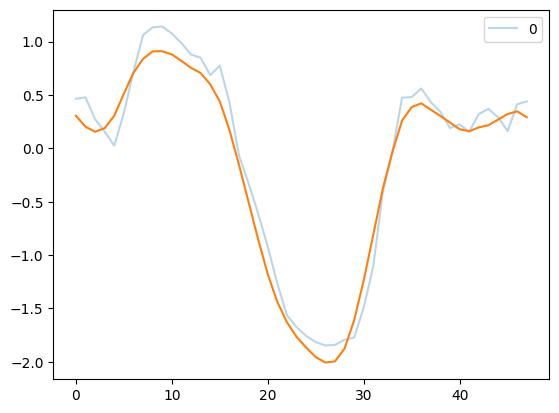

In [55]:
idx = 11
sns.lineplot(
    data[idx]["subset"],
    alpha=0.3,
    linestyle="--",
)

sns.lineplot(
    predicted_ts[idx]["prev_subset"].flatten(),
)
# mse_val = F.mse_loss(pred_ts_values, pred_ts_values_true)
# plt.title(f"MSE = {mse_val:.4f}")

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()